In [1]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from neurogym import spaces
import numpy as np
import gym  # package for RL environments
import neurogym as ngym

# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}



class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

# New Custom Perceptual Decision Making with Delay

In [4]:
class CustomPerceptualDecisionMakingDelayResponse(ngym.TrialEnv):
    """Two-alternative forced choice task in which the subject has to
    integrate two stimuli to decide which one is higher on average.
    A noisy stimulus is shown during the stimulus period. The strength (
    coherence) of the stimulus is randomly sampled every trial. Because the
    stimulus is noisy, the agent is encouraged to integrate the stimulus
    over time.
    Args:
        cohs: list of float, coherence levels controlling the difficulty of
            the task
        sigma: float, input noise level
        dim_ring: int, dimension of ring input and output (also corresponds to 
            the number of options for groundtruth)
    """
    metadata = {
        'paper_link': 'https://www.jneurosci.org/content/12/12/4745',
        'paper_name': '''The analysis of visual motion: a comparison of
        neuronal and psychophysical performance''',
        'tags': ['perceptual', 'two-alternative', 'supervised']
    }

    # TODO dim_ring may be too simple 
    def __init__(self, dt=100, rewards=None, timing=None, cohs=None,
                 sigma=1.0, dim_ring=2):
        super().__init__(dt=dt)
        if cohs is None:
            self.cohs = np.array([0, 6.4, 12.8, 25.6, 51.2])
        else:
            self.cohs = cohs
        self.sigma = sigma / np.sqrt(self.dt)  # Input noise

        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 100,
            'stimulus_1': 2000,
            'stimulus_2': 2000,
            'delay': 600,
            'decision': 100}
        if timing:
            self.timing.update(timing)

        self.abort = False

        self.theta = 3.14159265
        # TODO how does this work when visualized?
        self.choices = np.arange(0,2) # index for the "choices" variable in the action space

        name = {'fixation': 0, 'stimulus': 1}
        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(2,), dtype=np.float32, name=name)
        name = {'fixation': 0, 'choice': range(1, 3)}
        self.action_space = spaces.Discrete(3, name=name)

    def _new_trial(self, **kwargs):
        """
        new_trial() is called when a trial ends to generate the next trial.
        The following variables are created:
            durations, which stores the duration of the different periods (in
            the case of perceptualDecisionMaking: fixation, stimulus and
            decision periods)
            ground truth: correct response for the trial
            coh: stimulus coherence (evidence) for the trial
            obs: observation
        """
        # ---------------------------------------------------------------------
        # Trial
        # ---------------------------------------------------------------------
        trial = {
            'ground_truth': self.rng.choice(self.choices),
            'coh': self.rng.choice(self.cohs),
        }
        trial.update(kwargs)

        coh = trial['coh']
        ground_truth = trial['ground_truth']
        rand_int = np.random.randint(0, 2)
        if ground_truth: 
            # when gt == 1 -> [action_space["choices"][1]; the two stimulis are different 
            if rand_int:
                stim_2_theta = self.theta
                stim_1_theta = 0
            else:
                stim_1_theta = self.theta
                stim_2_theta = 0
        else:
            # when gt == 0 -> [action_space["choices"][0]; the two stimulis are the same 
            if rand_int:
                stim_1_theta = stim_2_theta = self.theta
            else:
                stim_1_theta = stim_2_theta = 0
        # ---------------------------------------------------------------------
        # Periods
        # ---------------------------------------------------------------------
        self.add_period(['fixation', 'stimulus_1', 'stimulus_2', 'delay', 'decision'])

        # define observations
        self.add_ob(1, period=['fixation', 'stimulus_1', 'stimulus_2', 'delay'], where='fixation')
        # len(np.arr - const.) == 2
        stim_1 = np.cos(stim_1_theta) * (coh/200) + 0.5
        stim_2 = np.cos(stim_2_theta) * (coh/200) + 0.5
        print(f"ground_truth = {ground_truth}", flush=True)
        print(f"stim_1_theta = {stim_1_theta}", flush=True)
        print(f"stim_2_theta = {stim_2_theta}", flush=True)
        # print(f"stim_1 = {stim_1}", flush=True)
        # print(f"stim_2 = {stim_2}", flush=True)
        self.add_ob(stim_1, period='stimulus_1', where='stimulus')
        self.add_ob(stim_2, period='stimulus_2', where='stimulus')
        # add noise to stimulus
        self.add_randn(0, self.sigma, period='stimulus_1', where='stimulus')
        self.add_randn(0, self.sigma, period='stimulus_2', where='stimulus')

        # Ground truth
        self.set_groundtruth(ground_truth, period='decision', where='choice')

        return trial

    def _step(self, action):
        # TODO change how reward is calculated
        """
        _step receives an action and returns:
            a new observation, obs
            reward associated with the action, reward
            a boolean variable indicating whether the experiment has end, done
            a dictionary with extra information:
                ground truth correct response, info['gt']
                boolean indicating the end of the trial, info['new_trial']
        """
        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}

# Create environment from source code
env = CustomPerceptualDecisionMakingDelayResponse(dt=80, sigma=0.22)
_ = ngym.utils.plot_env(env, num_trials=1)

ground_truth = 0
stim_1_theta = 3.14159265
stim_2_theta = 3.14159265
stim_1 = 0.244
stim_2 = 0.244
ground_truth = 0
stim_1_theta = 0
stim_2_theta = 0
stim_1 = 0.532
stim_2 = 0.532


findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

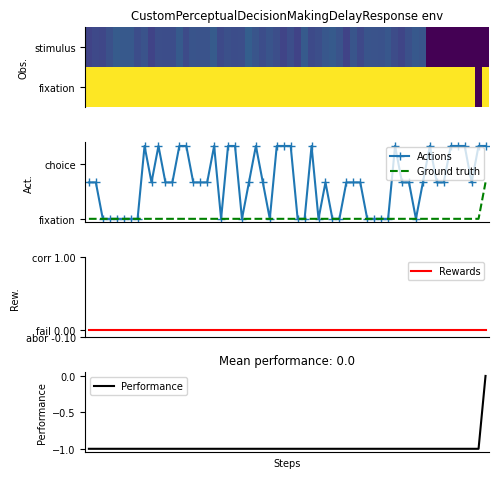

In [3]:
_ = ngym.utils.plot_env(env, num_trials=1)

# Visualize the environment with 2 sample trials

In [ ]:
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Instantiate the network and print information

In [ ]:
# This is a simple task, the input and output are low-dimensional
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
print('Input size', input_size)
print('Output size', output_size)

hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)

if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)

net.to(device)

print(net)